# 3 Data analyses
## 3.3 Gradient-boosted model
### Set up environment

In [1]:
### Import packages.

import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from scipy import stats


In [2]:
### Load records and perform checks.

# Load 30-year records from each target station.
COH726_original = pd.read_csv(r'C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Data_Products/COH726_30yr.csv')
LYN614_original = pd.read_csv(r'C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Data_Products/LYN614_30yr.csv')
WEY738_original = pd.read_csv(r'C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Data_Products/WEY738_30yr.csv')

# Test: The records are 30 years long.
n = 360 # Length of record in months.
assert (len(COH726_original) == n) & (len(LYN614_original) == n) & (len(WEY738_original) == n), "One or more records do not contain exactly 30 years of data." 

# Test: Record lengths are equal across datasets.
assert (len(COH726_original) == len(LYN614_original)) & (len(WEY738_original) == len(LYN614_original)), "One or more records are unequal lengths."


In [3]:
### Index all records by date and add 48 more rows to capture an additional 4 years of predictions.

# Create dates for the sample range and a four-year period afterwards.
dates = pd.date_range('1-1-1990', periods=408, freq="M")

# Create a dataframe to hold the additional 4 years of broken down date data.
# Create a list of years. Multiply by 12 so there are 4-years' worth of years. 
year = [2020, 2021, 2022, 2023] * 12
year.sort()

# Create a list of month numbers. Mulitply by 4 so there are 4-years' worth of months.
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] * 4

# Create a dataframe to hold the additional 4 years of broken down date data.
pred_dates = pd.DataFrame({'Year': year, 'Month': month})

### Format the records and index by date.
# Copy the data for modification.
COH726_data = COH726_original

# Drop exccess columns.
COH726_data = COH726_data.drop(['Unnamed: 0', 'Station'], axis = 1)

# Add an additional 48 rows to the dataframe
COH726_data = pd.concat([COH726_data, pred_dates], ignore_index=True)

# Add the date range of the sample to the data.
COH726_data['Dates'] = dates

# Repeat for LYN614.
LYN614_data = LYN614_original
LYN614_data = LYN614_data.drop(['Unnamed: 0', 'Station'], axis = 1)
LYN614_data = pd.concat([LYN614_data, pred_dates], ignore_index=True)
LYN614_data['Dates'] = dates

# Repeat for WEY738.
WEY738_data = WEY738_original
WEY738_data = WEY738_data.drop(['Unnamed: 0', 'Station'], axis = 1)
WEY738_data = pd.concat([WEY738_data, pred_dates], ignore_index=True)
WEY738_data['Dates'] = dates


### LightGBM (Gradient boosted models)


In [4]:
### Create function to run LightGBM regressions.

# Create a function to run LightGBM regressions and return testing and training period predictions.
def LightGBMRegressor_predictions(station_data):
    # Separate data into x and y datasets.
    # x contains all data except precip and dates.
    x = station_data.drop(['Precipitation', 'Dates'], axis = 1)
    # y contains precip data.
    y = station_data['Precipitation']

    # Set 4-year test period (from end 2015 to end 2019) and 4 year post-data-range prediction period (from end 2019 to end 2023)
    horizon_1 = 48
    horizon_2 = 96

    # Separate out test and train precip data based on horizon value.
    x_train = x.iloc[:-horizon_2]
    x_test = x.iloc[-horizon_2:-horizon_1]
    x_future = x.iloc[-horizon_1:]
    
    y_train = y.iloc[:-horizon_2]
    y_test = y.iloc[-horizon_2:-horizon_1]
    
    # Load and train the model (Light Gradient Boosting).
    model = lgb.LGBMRegressor()
    model.fit(x_train, y_train)

    # Apply the model to the testing data. How well does this do on novel data?
    predictions_test_range = model.predict(x_test)

    # Apply the model to the training data. How well can this model replicate the data on a longer (but known) scale?
    predictions_train_range = model.predict(x_train)
    
    # Apply the model to a date range outside the data collection period. 
    predictions_after_data_range = model.predict(x_future)

    # Convert arrays to lists.
    predictions_test_range = predictions_test_range.tolist()
    predictions_train_range = predictions_train_range.tolist()
    predictions_after_data_range = predictions_after_data_range.tolist()
    
    # Combine all predictions into one list
    predictions = predictions_train_range + predictions_test_range + predictions_after_data_range
    
    return predictions
 

#### Non-normalized data

In [5]:
### Run functions to model precipitation.

# Apply function to COH726 data.
predictions = LightGBMRegressor_predictions(COH726_data)

# Add to dataframe.
COH726_data['Predictions'] = predictions
COH726_data

# Set dates as the index.
COH726_data.index = COH726_data['Dates']

# Repeat for LYN614.
predictions = LightGBMRegressor_predictions(LYN614_data)
LYN614_data['Predictions'] = predictions
LYN614_data.index = LYN614_data['Dates']

# Repeat for WEY738.
predictions = LightGBMRegressor_predictions(WEY738_data)
WEY738_data['Predictions'] = predictions
WEY738_data.index = WEY738_data['Dates']


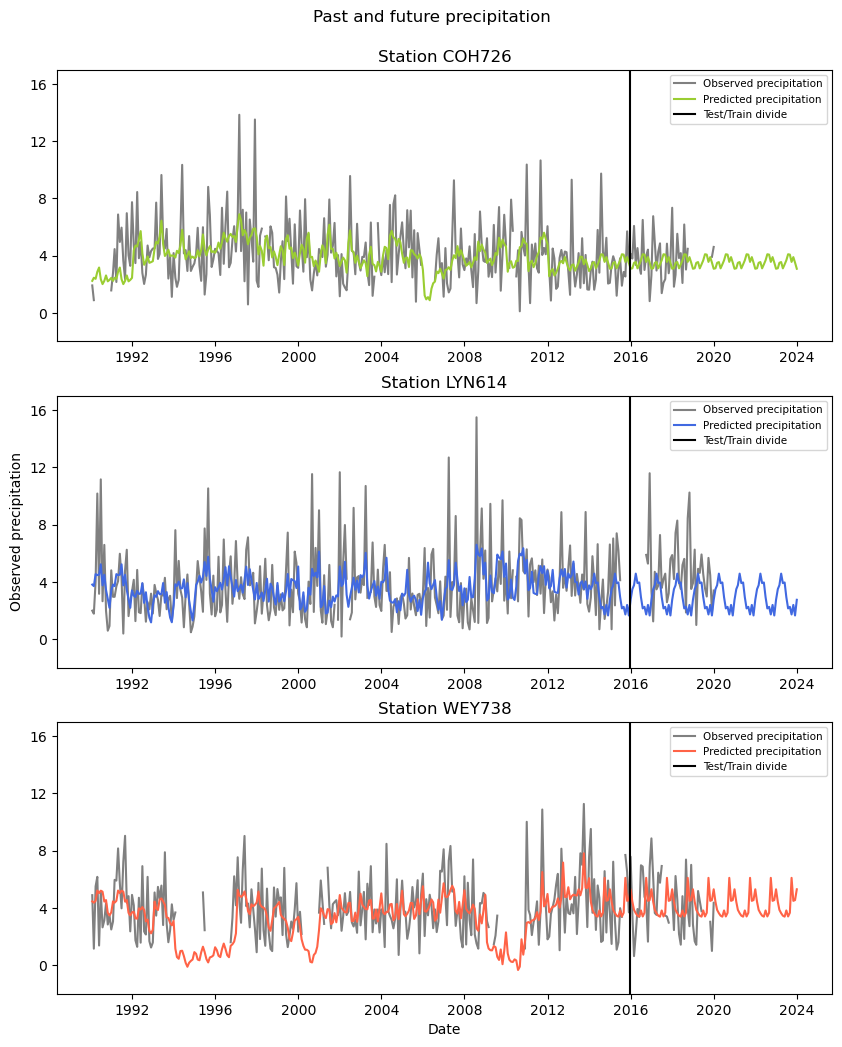

In [17]:
### Plot precipitation and predictions.

# Convert date to number of days.
test_train_split_date = (2020-1970-4)*365

# Create range of row positions.
y_positions = range(-4, 17, 4)
y_names = range(-4, 17, 4)

# Set up figure with three sub-figures in one column.
fig, axs = plt.subplots(3, figsize = [10, 12])

# Format a main title.
fig.suptitle('Past and future precipitation', y = 0.93)

# Set title for first sub-figure.
axs[0].set_title('Station COH726')

# Plot the obsserved and predicted data for COH726.
axs[0].plot(COH726_data['Precipitation'], color = 'grey', label = 'Observed precipitation')
axs[0].plot(COH726_data['Predictions'], color = 'yellowgreen', label = 'Predicted precipitation')

# Format y-axis.
axs[0].set(yticks = y_positions, yticklabels = y_names)
axs[0].set_ylim(-2, 17)

# Add line at test-train divide.
axs[0].axvline(x=test_train_split_date, label='Test/Train divide', color='black')

# Add a legend.
axs[0].legend(loc='upper right', fontsize = '7.5')

# Plot the obsserved and predicted data for LYN614, the test-train divide line, the title, and the legend.
axs[1].plot(LYN614_data['Precipitation'], color = 'grey', label = 'Observed precipitation')
axs[1].plot(LYN614_data['Predictions'], color = 'royalblue', label = 'Predicted precipitation')
axs[1].set(yticks = y_positions, yticklabels = y_names)
axs[1].set_ylim(-2, 17)
axs[1].axvline(x=test_train_split_date, label='Test/Train divide', color='black')
axs[1].legend(loc='upper right', fontsize = '7.5')
axs[1].set_title('Station LYN614')

# Plot the obsserved and predicted data for WEY738, the test-train divide line, the title, and the legend.
axs[2].plot(WEY738_data['Precipitation'], color = 'grey', label = 'Observed precipitation')
axs[2].plot(WEY738_data['Predictions'], color = 'tomato', label = 'Predicted precipitation')
axs[2].set(yticks = y_positions, yticklabels = y_names)
axs[2].set_ylim(-2, 17)
axs[2].axvline(x=test_train_split_date, label='Test/Train divide', color='black')
axs[2].legend(loc='upper right', fontsize = '7.5')
axs[2].set_title('Station WEY738')

# Add a label to the x- and y- axes.
axs[1].set(ylabel = 'Observed precipitation')
axs[2].set(xlabel = 'Date')

# Save figure.
plt.savefig('C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Image_Products/LightGBM_predictions.png')


In [7]:
### Perform regression on predicted and actual data.

# Drop the NA values.
COH726_data_noNaNs = COH726_data.dropna(axis=0)

# Perform two-sided linear regression for COH726 actual and predicted values.
COH_res = stats.linregress(COH726_data_noNaNs['Precipitation'], COH726_data_noNaNs['Predictions'], alternative = "two-sided")

# Repeat for LYN614 station.
LYN614_data_noNaNs = LYN614_data.dropna(axis=0)
LYN_res = stats.linregress(LYN614_data_noNaNs['Precipitation'], LYN614_data_noNaNs['Predictions'], alternative = "two-sided")

# Repeat for WEY638 station.
WEY738_data_noNaNs = WEY738_data.dropna(axis=0)
WEY_res = stats.linregress(WEY738_data_noNaNs['Precipitation'], WEY738_data_noNaNs['Predictions'], alternative = "two-sided")

# Combine results into dataframe.
linReg_res = pd.DataFrame([COH_res, LYN_res, WEY_res])

# Rename the index.
linReg_res.index = ["COH", "LYN", "WEY"]

# Transpose the entire dataframe.
linReg_res = linReg_res.transpose()

# Save the table.
linReg_res.to_csv('C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Data_Products/LightGBM_linreg_res.csv', index = True)


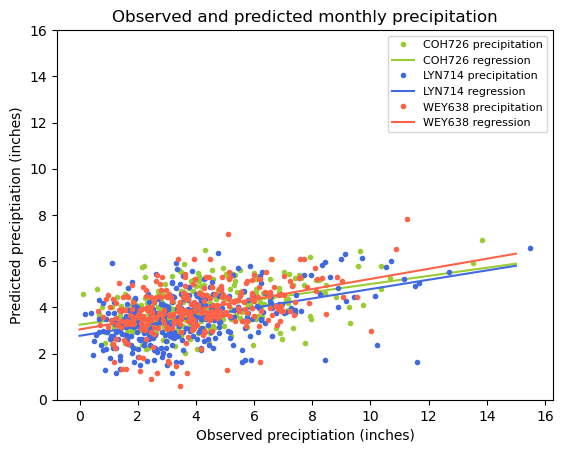

In [8]:
### Plot predicted and actual data and regression lines.

# Create range of x-values.
x = range(0,16)

# Factor slope and intercept as separate values.
COH_slope = linReg_res['COH']['slope']
COH_int = linReg_res['COH']['intercept']

# Calculate y-values from 'y = m*x + b'.
COH_y = COH_slope*x + COH_int

# Repeat for LYN614 station.
LYN_slope = linReg_res['LYN']['slope']
LYN_int = linReg_res['LYN']['intercept']
LYN_y = LYN_slope*x + LYN_int

# Repeat for WEY638 station.
WEY_slope = linReg_res['WEY']['slope']
WEY_int = linReg_res['WEY']['intercept']
WEY_y = WEY_slope*x + WEY_int

# Plot actual and predicted values for COH726.
plt.plot(COH726_data['Precipitation'], COH726_data['Predictions'], '.', color='yellowgreen', label = 'COH726 precipitation')

# Plot regression line for COH726.
plt.plot(x, COH_y, color='yellowgreen', label = 'COH726 regression')

# Repeat for LYN614.
plt.plot(LYN614_data['Precipitation'], LYN614_data['Predictions'], '.', color='royalblue', label = "LYN714 precipitation")
plt.plot(x, LYN_y, color='royalblue', label = 'LYN714 regression')

# Repeat for WEY638.
plt.plot(WEY738_data['Precipitation'], WEY738_data['Predictions'], '.', color='tomato', label = "WEY638 precipitation")
plt.plot(x, WEY_y, color='tomato', label = 'WEY638 regression')

# Set y-axis limits.
plt.ylim([0, 16])

# Add title and axes labels.
plt.title('Observed and predicted monthly precipitation')
plt.xlabel('Observed preciptiation (inches)')
plt.ylabel('Predicted preciptiation (inches)')

# Add a legend with labels assigned above.
plt.legend(loc='upper right', fontsize = '8') 

# Save the figure.
plt.savefig('C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Image_Products/LightGBM_predictions_vs_actual.png')


#### Normalized data

In [9]:
### Normalize all datasets, rerun all models, and save AIC values.

# Duplicate dateframe.
COH726_normed = COH726_data

# Convert data to numeric type.
COH726_num = pd.to_numeric(COH726_normed['Precipitation'])

# Drop columns that will be replaced with normalized data and predictions.
COH726_normed = COH726_normed.drop(['Precipitation', 'Predictions'], axis = 1)

# Feature scaling / Min-max-normalize the data.
normed_data = [((x - COH726_num.min()) / (COH726_num.max() - COH726_num.min())) for x in COH726_num]

# Convert to dataframe.
COH726_normed['Precipitation'] = normed_data

# Repeat for LYN614.
LYN614_normed = LYN614_data
LYN614_num = pd.to_numeric(LYN614_normed['Precipitation'])
LYN614_normed = LYN614_normed.drop(['Precipitation', 'Predictions'], axis = 1)
normed_data = [((x - LYN614_num.min()) / (LYN614_num.max() - LYN614_num.min())) for x in LYN614_num]
LYN614_normed['Precipitation'] = normed_data

# Repeat for WEY738.
WEY738_normed = WEY738_data
WEY738_num = pd.to_numeric(WEY738_normed['Precipitation'])
WEY738_normed = WEY738_normed.drop(['Precipitation', 'Predictions'], axis = 1)
normed_data = [((x - WEY738_num.min()) / (WEY738_num.max() - WEY738_num.min())) for x in WEY738_num]
WEY738_normed['Precipitation'] = normed_data


In [10]:
### Run functions to model precipitation.

# Apply function  to COH726 data.
predictions = LightGBMRegressor_predictions(COH726_normed)

# Add to dataframe.
COH726_normed['Predictions'] = predictions

# Set dates as the index.
COH726_data.index = COH726_data['Dates']

# Repeat for LYN614.
predictions = LightGBMRegressor_predictions(LYN614_normed)
LYN614_normed['Predictions'] = predictions
LYN614_data.index = LYN614_data['Dates']

# Repeat for WEY738.
predictions = LightGBMRegressor_predictions(WEY738_normed)
WEY738_normed['Predictions'] = predictions
WEY738_data.index = WEY738_data['Dates']


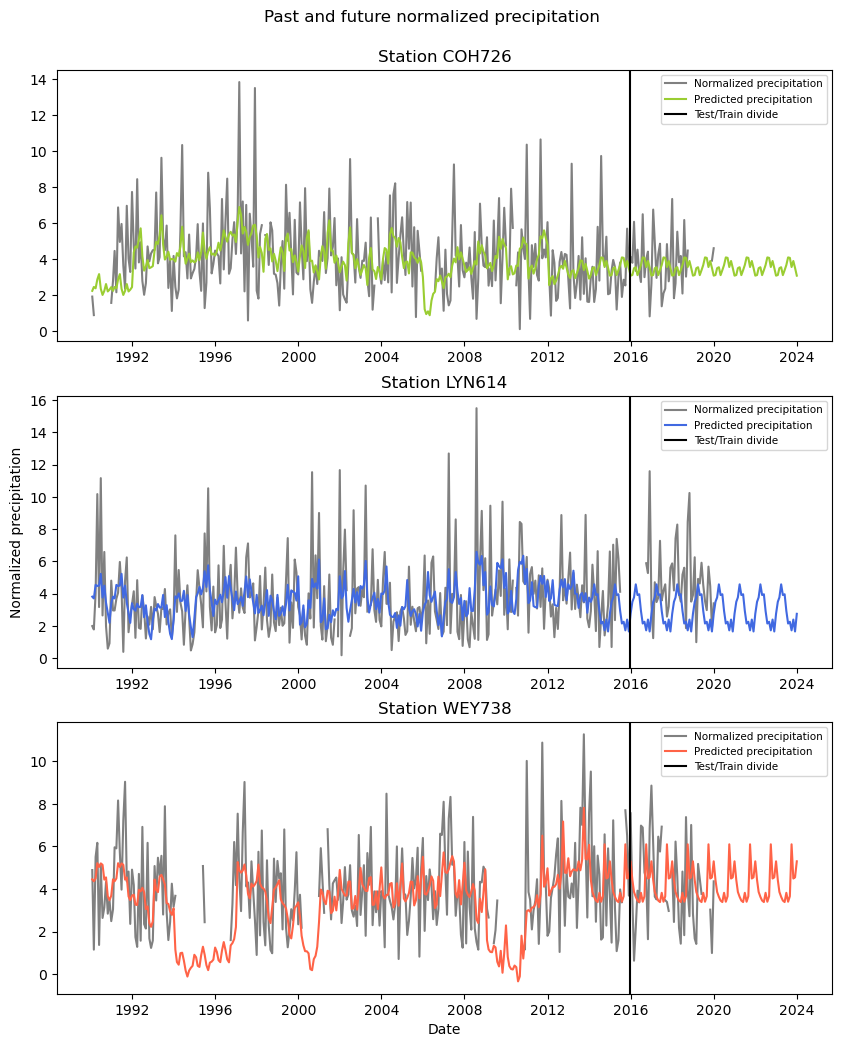

In [18]:
### Plot precipitation and predictions.

# Convert date to number of days.
test_train_split_date = (2020-1970-4)*365

# Set up figure with three sub-figures in one column.
fig, axs = plt.subplots(3, figsize = [10, 12])

# Format a main title.
fig.suptitle('Past and future normalized precipitation', y = 0.93)

# Set title for first sub-figure.
axs[0].set_title('Station COH726')

# Plot the obsserved and predicted data for COH726.
axs[0].plot(COH726_data['Precipitation'], color = 'grey', label = 'Normalized precipitation')
axs[0].plot(COH726_data['Predictions'], color = 'yellowgreen', label = 'Predicted precipitation')

# Format y-axis.
#axs[0].set(yticks = y_positions, yticklabels = y_names)
#axs[0].set_ylim(-2, 17)

# Add line at test-train divide.
axs[0].axvline(x=test_train_split_date, label='Test/Train divide', color='black')

# Add a legend.
axs[0].legend(loc='upper right', fontsize = '7.5')

# Plot the obsserved and predicted data for LYN614, the test-train divide line, the title, and the legend.
axs[1].plot(LYN614_data['Precipitation'], color = 'grey', label = 'Normalized precipitation')
axs[1].plot(LYN614_data['Predictions'], color = 'royalblue', label = 'Predicted precipitation')
axs[1].axvline(x=test_train_split_date, label='Test/Train divide', color='black')
axs[1].legend(loc='upper right', fontsize = '7.5')
axs[1].set_title('Station LYN614')

# Plot the obsserved and predicted data for WEY738, the test-train divide line, the title, and the legend.
axs[2].plot(WEY738_data['Precipitation'], color = 'grey', label = 'Normalized precipitation')
axs[2].plot(WEY738_data['Predictions'], color = 'tomato', label = 'Predicted precipitation')
axs[2].axvline(x=test_train_split_date, label='Test/Train divide', color='black')
axs[2].legend(loc='upper right', fontsize = '7.5')
axs[2].set_title('Station WEY738')

# Add a label to the x- and y- axes.
axs[1].set(ylabel = 'Normalized precipitation')
axs[2].set(xlabel = 'Date')

# Save figure.
plt.savefig('C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Image_Products/LightGBM_predictions_normed.png')


In [14]:
### Perform regression on predicted and actual data.

# Drop te NA values.
COH726_data_noNaNs = COH726_normed.dropna(axis=0)

# Perform two-sided linear regression for COH726 actual and predicted values.
COH_res = stats.linregress(COH726_data_noNaNs['Precipitation'], COH726_data_noNaNs['Predictions'], alternative = "two-sided")

# Repeat for LYN614 station.
LYN614_data_noNaNs = LYN614_normed.dropna(axis=0)
LYN_res = stats.linregress(LYN614_data_noNaNs['Precipitation'], LYN614_data_noNaNs['Predictions'], alternative = "two-sided")

# Repeat for WEY638 station.
WEY738_data_noNaNs = WEY738_normed.dropna(axis=0)
WEY_res = stats.linregress(WEY738_data_noNaNs['Precipitation'], WEY738_data_noNaNs['Predictions'], alternative = "two-sided")

# Combine results into dataframe.
linReg_res = pd.DataFrame([COH_res, LYN_res, WEY_res])

# Rename the index.
linReg_res.index = ["COH", "LYN", "WEY"]

# Transpose the entire dataframe.
linReg_res = linReg_res.transpose()

# Save the table.
linReg_res.to_csv('C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Data_Products/LightGBM_linreg_res_normed.csv', index = True)


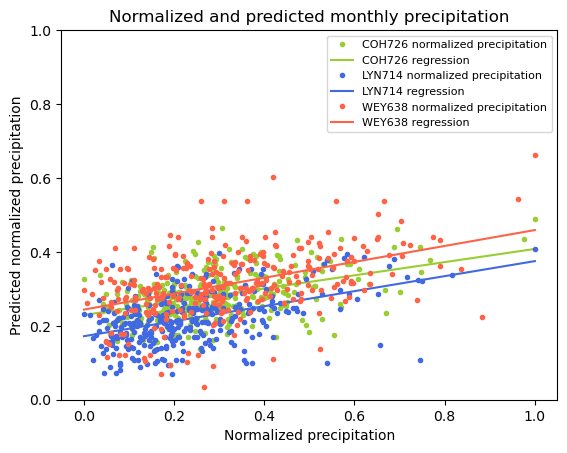

In [15]:
### Plot predicted and actual data and regression lines.

# Create range of x-values.
x = range(0,2)

# Factor slope and intercept as separate values.
COH_slope = linReg_res['COH']['slope']
COH_int = linReg_res['COH']['intercept']

# Calculate y-values from 'y = m*x + b'.
COH_y = COH_slope*x + COH_int

# Repeat for LYN614 station.
LYN_slope = linReg_res['LYN']['slope']
LYN_int = linReg_res['LYN']['intercept']
LYN_y = LYN_slope*x + LYN_int

# Repeat for WEY638 station.
WEY_slope = linReg_res['WEY']['slope']
WEY_int = linReg_res['WEY']['intercept']
WEY_y = WEY_slope*x + WEY_int

# Plot actual and predicted values for COH726.
plt.plot(COH726_normed['Precipitation'], COH726_normed['Predictions'], '.', color='yellowgreen', label = 'COH726 normalized precipitation')

# Plot regression line for COH726.
plt.plot(x, COH_y, color='yellowgreen', label = 'COH726 regression')

# Repeat for LYN614.
plt.plot(LYN614_normed['Precipitation'], LYN614_normed['Predictions'], '.', color='royalblue', label = "LYN714 normalized precipitation")
plt.plot(x, LYN_y, color='royalblue', label = 'LYN714 regression')

# Repeat for WEY638.
plt.plot(WEY738_normed['Precipitation'], WEY738_normed['Predictions'], '.', color='tomato', label = "WEY638 normalized precipitation")
plt.plot(x, WEY_y, color='tomato', label = 'WEY638 regression')

# Set y-axis limits.
plt.ylim([0, 1])

# Add title and axes labels.
plt.title('Normalized and predicted monthly precipitation')
plt.xlabel('Normalized precipitation')
plt.ylabel('Predicted normalized precipitation')

# Add a legend with labels assigned above.
plt.legend(loc='upper right', fontsize = '8') 

# Save the figure.
plt.savefig('C:/Users/evamb/OneDrive/Documents/Github/MAPrecipData/Image_Products/LightGBM_predictions_vs_normed.png')
